# SRM (Structurally Random Matrices)
1. SRMs involved three operators
    * R
        * Randomizer
    * F
        * Sparsity inducing transform (Eg: Hadamard)
    * D
        * Random measurements

In [4]:
import numpy as np
import scipy.fftpack as spfft
from scipy.linalg import hadamard
from scipy.ndimage import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt

# from wavelets_cdf97 import cdf97
from wavelets_cdf97 import cdf97_matlab

%matplotlib inline
%load_ext autoreload

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SRM Class

In [5]:
class DCT():
    
    def dct2(self, x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def idct2(self, x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

class SRM():
    def __init__(self, url, sparsifying_transform = 'dct2', MR = 0.5, L = 0):
        if isinstance(url, str):
            if url == '':
                self.url = '../../data/lena512.bmp'
            else:
                self.url = url
            self.img = imread(self.url, flatten = True)
        
        elif isinstance(url, np.ndarray) or isinstance(url, list):
            self.img = np.array(url)
            
        self.nx = self.img.shape[0]
        self.ny = self.img.shape[1]
        self.N = self.nx * self.ny
        self.img_vector = self.img.reshape((self.N, 1))
        self.blk_size = self.nx
        self.MR = MR
        self.k = int(self.N * self.MR)
        self.transform_type  = 'BWHT'
        self.randomizer_type = 'idx_permutation'  #sign_flipping
        self.sparsifying_transform = sparsifying_transform
        self.L = L
        
        """
        TESTS
        """
        if self.N % self.blk_size != 0:
            print (' Block Size (', self.blk_size,') needs to be divisible by N(',self.N,')')
            import sys; sys.exit(1)
        
        if self.L == 0 and self.sparsifying_transform == 'daubechies_9_7':
            print ('[SRM][Error] Number of wavelet levels:', self.L, ' !!!')
            import sys; sys.exit(1)
        
        self.measurement_matrices()
        
        self.phi_test    = lambda z : self.Phi  (z        , self.select_vect, self.rand_vect, self.transform_type, self.blk_size, show = 1)
        self.phi_T_test  = lambda z : self.Phi_T(z, self.N, self.select_vect, self.rand_vect, self.transform_type, self.blk_size, show = 1)
        
        self.phi    = lambda z : self.Phi  (z        , self.select_vect, self.rand_vect, self.transform_type, self.blk_size, show = 0)
        self.phi_T  = lambda z : self.Phi_T(z, self.N, self.select_vect, self.rand_vect, self.transform_type, self.blk_size, show = 0)
        
        self.A      = lambda z  : self.A_idwt1d(self.phi  , z, self.sparsifying_transform, self.nx, self.ny);
        self.A_T    = lambda z  : self.At_dwt1d(self.phi_T, z, self.sparsifying_transform, self.nx, self.ny);
    
    # Called by init
    def measurement_matrices(self):
        """
        Define measurement matrices
        """
        self.rand_vect = []
        self.select_vect = []
        if self.randomizer_type == 'idx_permutation':
            self.rand_vect = np.random.permutation(self.N)
        if self.transform_type == 'BWHT':
            self.select_vect = np.random.permutation(self.N)[:self.k] #select the first k variables 
          
    
    #block based sensing operator (formward)
    def Phi(self, x, select_vect, rand_vect, trans_mode, blk_size, show = 1): #DFR (x)
        # x - original image vector
        
        N = len(x)
        fx = np.array(x).astype(np.float16)
        if show:
            f1, axarr1 = plt.subplots(1,2)
        if trans_mode == 'BWHT':
            # Step1(R) : Randomizer (contribution of SRMs to Compressive Sensing)
            fx[rand_vect] = np.array(x)
            if show: 
                axarr1[0].imshow(fx.reshape((blk_size), int(np.floor(N/blk_size))), cmap = 'gray')
                axarr1[0].set_title('Randomized Image')
            
            # Step2(F) : Multiplying by Transform matrix
            fx = fx.reshape((blk_size), int(np.floor(N/blk_size)))
            F = hadamard(blk_size)/np.sqrt(blk_size)
            fx = F * fx
            if show: 
                axarr1[1].imshow(fx, cmap = 'gray')
                axarr1[1].set_title('Hadamard Transformed')
            
            #Step3(D) : Take k measurements
            fx = fx.reshape((N, 1))
            b = np.array(fx[select_vect])
            return b
    
    #block based sensing operator (transpose)
    def Phi_T(self, b, N, select_vect, rand_vect, trans_mode, blk_size, show = 1): #RFD (b)
        if show:
            f2, axarr2 = plt.subplots(1,3, figsize=(10,10))
        if trans_mode == 'BWHT':
            #Step1 (D) : Create the original transform array
            k = len(b)
            fx = np.zeros((N,1))
            fx[select_vect] = np.array(b[:k])
            if show: 
                axarr2[0].imshow(fx.reshape((blk_size, int(np.floor(N/blk_size)))), cmap = 'gray')
                axarr2[0].set_title('Hadamard Transformed')
                
            #Step2 (F) : 
            fx = fx.reshape((blk_size, int(np.floor(N/blk_size))))
            F = hadamard(blk_size)/np.sqrt(blk_size)
            fx = F.T * fx
            fx = fx.reshape((N,1))
            if show : 
                axarr2[1].imshow(fx.reshape((self.nx,self.ny)), cmap = 'gray') 
                axarr2[1].set_title('Inverse Hadamard')
            
            #Step3 (R)
            x = np.array(fx[rand_vect])
            if show : 
                axarr2[2].imshow(x.reshape((self.nx, self.ny)), cmap = 'gray')
                axarr2[2].set_title('De-Randomized Image')
            return x
        
    
    # ~~~
    def A_idwt1d(self, A, x_sparse, sparsifying_transform, nx, ny):
        # I/P = x_sparse : sparse vector taken from Wavelet transform of X
        # O/P = b        : K, 1 
        # A              : random projection matrix K x N

        # Step1 (convert to image)
        x_sparse_tmp = x_sparse.reshape((nx,ny))
        if sparsifying_transform == 'daubechies_9_7':
            cdf97_obj = cdf97_matlab()
            h0,h1,f0,f1 = cdf97_obj.filter9_7(verbose = 0)
            img = cdf97_obj.idwt2d(x_sparse_tmp, f0, f1, self.L)
        elif sparsifying_transform == 'dct2':
            img = DCT().idct2(x_sparse_tmp)

        # Step2 (get b from the image)
        N = nx * ny
        x = img.reshape((N,1))
        b = A(x)  #b = phi.psi(x) #phi=A, psi=transform
        return b

    # ~~~
    def At_dwt1d(self, At, b, sparsifying_transform, nx, ny):
        # I/P = b         : K x 1
        # O/P = x_sparse  : N x 1
        
        # Step1 (Recover img from b->measurement vector)
        x = At(b)
        im = np.array(x.reshape((nx,ny)))
        
        # Step2 (Convert img to sparse vector)
        if sparsifying_transform == 'daubechies_9_7':
            cdf97_obj = cdf97_matlab()
            h0,h1,f0,f1 = cdf97_obj.filter9_7(verbose = 0)
            x_sparse_tmp = np.array(cdf97_obj.dwt2d(im, h0, h1, self.L))
        elif sparsifying_transform == 'dct2':
            x_sparse_tmp = DCT().dct2(im)

        N = nx * ny
        x_sparse = x_sparse_tmp.reshape((N,1))
        
        # f, axarr = plt.subplots(1,2, figsize=(4,4))
        # axarr[0].imshow(im)
        # axarr[1].imshow(x_sparse_tmp, cmap = 'gray')
        
        return x_sparse

# Using SRM in an Algorithm

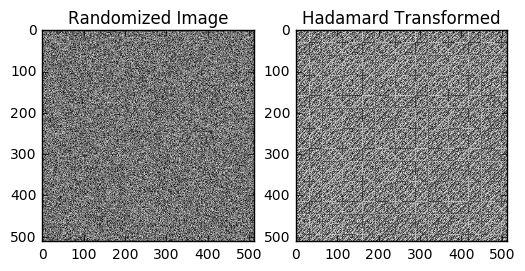

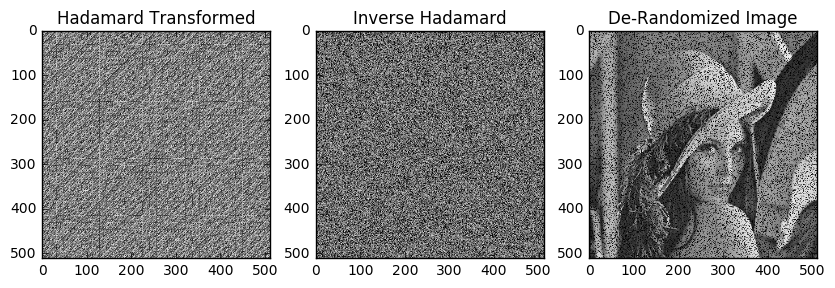

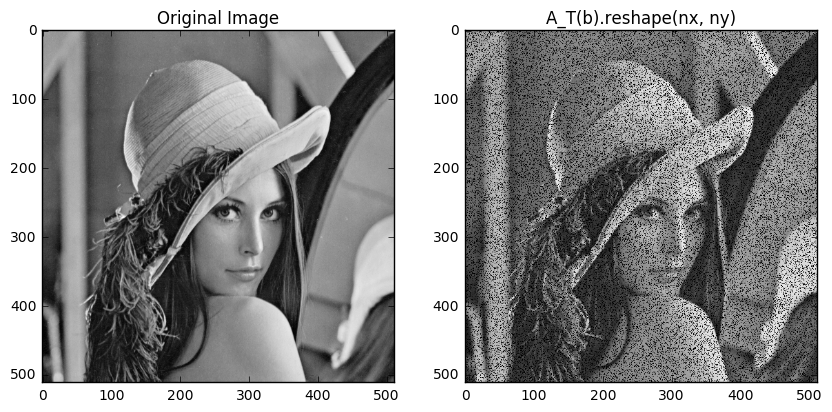

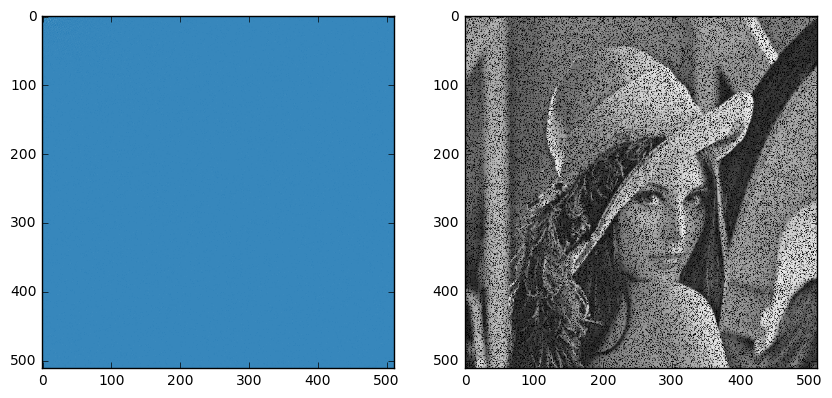

In [7]:
def test_phi():
    # TEST FOR PHI
    sparsifying_transform = 'dct2'
    SRM_obj = SRM('', sparsifying_transform = sparsifying_transform, MR = 0.8, L = 3)
    b = SRM_obj.phi_test(SRM_obj.img_vector)
    x = SRM_obj.phi_T_test(b)
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(SRM_obj.img, cmap = 'gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(x.reshape(SRM_obj.nx, SRM_obj.ny), cmap = 'gray')
    axarr[1].set_title('A_T(b).reshape(nx, ny)')
    
    if sparsifying_transform == 'daubechies_9_7':
        x_sparse = SRM_obj.A_T(b)
        x_sparse_tmp = x_sparse.reshape((SRM_obj.nx,SRM_obj.ny))
        cdf97_obj = cdf97_matlab()
        h0,h1,f0,f1 = cdf97_obj.filter9_7(verbose = 0)
        img_recon = cdf97_obj.idwt2d(x_sparse_tmp, f0, f1, SRM_obj.L)
        f1, axarr1 = plt.subplots(1,2, figsize=(10,10))
        axarr1[0].imshow(x_sparse_tmp, cmap = 'gray')
        axarr1[1].imshow(img_recon, cmap = 'gray')
    else:
        x_sparse = SRM_obj.A_T(b)
        x_sparse_tmp = x_sparse.reshape((SRM_obj.nx,SRM_obj.ny))
        img_recon = DCT().idct2(x_sparse_tmp)
        f1, axarr1 = plt.subplots(1,2, figsize=(10,10))
        axarr1[0].imshow(x_sparse_tmp, cmap = plt.cm.Paired)
        axarr1[1].imshow(img_recon, cmap = 'gray')

def test_A():
    # TEST FOR A
    SRM_obj = SRM('', MR = 0.8, show = 1)
    x = SRM_obj.A_T(b)
    b = SRM_obj.A(x)

def test_TwIST():
    # TwIST
    %autoreload 2
    from TwIST import TwIST_raw                                                                
    from GPSR import GPSR_raw

    SRM_obj = SRM('', MR = 0.8, show = 0)
    b = SRM_obj.phi(SRM_obj.img_vector)
    true_x = SRM_obj.img_vector
    A = SRM_obj.A
    A_T = SRM_obj.A_T
    tau = np.linalg.norm(b, ord = 'fro')/np.sqrt(SRM_obj.k)/16;   
    x, x_debias, objective, times, debias_start, mses, max_svd = TwIST_raw(b, A, tau, AT = A_T , true_x = true_x)
    # x, x_debias, objective, times, debias_start, mses, max_svd = GPSR_raw(b, A, tau, AT = A_T, true_x = true_x)
    
    x_recon = x.reshape((m,n))
    if len(x_debias):
        x_debias_recon = np.array(x_debias).reshape((m,n))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(img, cmap = 'gray')
        axarr[1].imshow(x_recon, cmap = 'gray')
        axarr[2].imshow(x_debias_recon, cmap = 'gray')
    else:
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img, cmap = 'gray')
        axarr[1].imshow(x_recon, cmap = 'gray')

    # x_recon_img = cdf97().fwt97_2d(x_recon)

if __name__ == "__main__":
    pass
#     test_phi()
#     test_A()
#     test_TwIST()
    
    

# EXPERIMENTATION

In [ ]:
# from wavelets_cdf97 import cdf97_matlab_sample
# nx = ny = 128
# cdf97_matlab_sample('../../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
#                     , nx, ny, resized = True, compress = False) 